# Final Portfolio Project — Classification Task (V5)
**Student:** Rmaads  
**Module:** 5CS037  
**Task:** Multi-class Classification (Accident Severity)

> **Goal:** Predict `Accident_severity` (*Slight Injury*, *Serious Injury*, *Fatal injury*) using structured accident, driver, road, and environmental information.


## 1. Setup and Dataset Loading

In this notebook, I will:
- Load the accident severity dataset from Google Drive (as used in class)
- Inspect data types, basic shape, and missing values
- Perform careful preprocessing (leakage removal, missing handling, feature engineering)
- Conduct **purposeful** EDA (few plots, each with short interpretation)
- Build and compare:
  - **Model 1:** Logistic Regression (baseline + tuned)
  - **Model 2:** Random Forest (baseline + tuned)
  - **Neural Network:** MLP (required, basic build)
- Use **Stratified 80/20 split** to preserve class proportions
- Evaluate using **macro-F1** (important for imbalanced classes)


In [4]:
# Core libraries (as allowed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
# Mount Google Drive (so the notebook runs in one click)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load dataset (same path style as you used)
data_path = "/content/drive/MyDrive/Datasets/Road_Accident_Severity_Classification.csv"
df_raw = pd.read_csv(data_path)

print("Dataset shape (rows, cols):", df_raw.shape)
df_raw.head()

Dataset shape (rows, cols): (12316, 32)


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [7]:
# Basic info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [8]:
# Missing values overview (count + %)
missing_count = df_raw.isna().sum()
missing_percent = (missing_count / len(df_raw)) * 100

missing_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_%": missing_percent
}).sort_values("Missing_%", ascending=False)

missing_table.head(20)

,Missing_Count,Missing_%
Defect_of_vehicle,4427,35.945112
Service_year_of_vehicle,3928,31.893472
Work_of_casuality,3198,25.966223
Fitness_of_casuality,2635,21.394933
Type_of_vehicle,950,7.713543
Types_of_Junction,887,7.202014
Driving_experience,829,6.731082
Educational_level,741,6.016564
Vehicle_driver_relation,579,4.701202
Owner_of_vehicle,482,3.913608


## 2. Preprocessing (before EDA)

**Why preprocessing first?**  
I want EDA to reflect the data after major issues are handled (leakage columns removed, missing values handled, key engineered features created).  
This avoids drawing conclusions from columns that will not be used in modelling.

### 2.1 Remove leakage and high-cardinality / text-heavy features

**Leakage features** are removed because they reflect casualty outcomes/condition and are typically known after the accident outcome.  
**Text/high-cardinality** features are removed because the project focuses on structured tabular modelling (no full NLP), and these columns often create noisy encodings.


In [9]:
# Make a working copy
df = df_raw.copy()

# 1) Leakage columns (removed)
leakage_cols = [
    "Casualty_severity",
    "Casualty_class",
    "Age_band_of_casualty",
    "Fitness_of_casuality"
]

# 2) High-cardinality / text-ish columns (removed for this coursework scope)
high_cardinality_cols = [
    "Cause_of_accident",
    "Vehicle_movement",
    "Type_of_collision",
    "Pedestrian_movement"
]

cols_to_drop = []
for col in leakage_cols:
    if col in df.columns:
        cols_to_drop.append(col)

for col in high_cardinality_cols:
    if col in df.columns:
        cols_to_drop.append(col)

print("Dropping (leakage + high-cardinality):", cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Shape after leakage/high-cardinality drop:", df.shape)

Dropping (leakage + high-cardinality): ['Casualty_severity', 'Casualty_class', 'Age_band_of_casualty', 'Fitness_of_casuality', 'Cause_of_accident', 'Vehicle_movement', 'Type_of_collision', 'Pedestrian_movement']
Shape after leakage/high-cardinality drop: (12316, 24)


### 2.2 Drop columns with very high missingness

In class, I learned:
- If **few rows** are missing, dropping rows can be acceptable.
- But if a column has a **large portion** missing, it can introduce noise and heavy guessing.

Here, I drop any column with **more than 10% missing values** (and justify this in the report).


In [10]:
# Identify columns with >10% missing and drop them
missing_percent_after = (df.isna().sum() / len(df)) * 100
cols_high_missing = list(missing_percent_after[missing_percent_after > 10].index)

print("Columns dropped due to >10% missing:", cols_high_missing)
df.drop(columns=cols_high_missing, inplace=True)

print("Shape after dropping high-missing columns:", df.shape)

Columns dropped due to >10% missing: ['Service_year_of_vehicle', 'Defect_of_vehicle', 'Work_of_casuality']
Shape after dropping high-missing columns: (12316, 21)


### 2.3 Feature engineering for time (avoid heavy datetime parsing)

Instead of complex datetime parsing, I extract **hour** using simple string operations.
Then I create a **TimeOfDay** bucket (Morning/Afternoon/Evening/Night).


In [11]:
# Create Hour from Time (simple, robust parsing)
# Time values look like '11:16:00'. We take the first part as hour.
if "Time" in df.columns:
    hour_values = []
    for value in df["Time"].astype(str):
        parts = value.split(":")
        if len(parts) >= 1 and parts[0].isdigit():
            hour_values.append(int(parts[0]))
        else:
            hour_values.append(np.nan)
    df["Hour"] = hour_values

    # Create TimeOfDay buckets
    time_of_day = []
    for h in df["Hour"]:
        if pd.isna(h):
            time_of_day.append("Unknown")
        elif 5 <= h <= 11:
            time_of_day.append("Morning")
        elif 12 <= h <= 16:
            time_of_day.append("Afternoon")
        elif 17 <= h <= 20:
            time_of_day.append("Evening")
        else:
            time_of_day.append("Night")
    df["TimeOfDay"] = time_of_day

    # Drop original Time to reduce cardinality
    df.drop(columns=["Time"], inplace=True)

print("Columns now include engineered time features:", [c for c in ["Hour", "TimeOfDay"] if c in df.columns])
df[["Hour", "TimeOfDay"]].head()

Columns now include engineered time features: ['Hour', 'TimeOfDay']


,Hour,TimeOfDay
0,17,Evening
1,17,Evening
2,17,Evening
3,1,Night
4,1,Night


### 2.4 Handle missing values (simple, explainable rules)

- For **numeric columns**, we check outliers using the IQR rule:
  - If outliers exist → fill missing with **median**
  - If no strong outliers → fill missing with **mean**
- For **categorical columns**, fill missing with `"Unknown"`.

Note: Some numeric columns (e.g., `Number_of_vehicles_involved`) often have no missing values, but the code is written generally.


In [12]:
# Separate numeric and categorical columns
target_col = "Accident_severity"
feature_cols = [c for c in df.columns if c != target_col]

numeric_cols = []
categorical_cols = []

for col in feature_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

print("Numeric columns:", numeric_cols)
print("Categorical columns (sample):", categorical_cols[:10], " ... total =", len(categorical_cols))

Numeric columns: ['Number_of_vehicles_involved', 'Number_of_casualties', 'Hour']
Categorical columns (sample): ['Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians']  ... total = 18


In [13]:
# IQR-based outlier check helper
def has_outliers_iqr(series):
    # Works on numeric series (ignores NaNs)
    values = series.dropna()
    if len(values) < 5:
        return False

    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_count = ((values < lower) | (values > upper)).sum()
    return outlier_count > 0

# Fill numeric missing values
fill_log = []
for col in numeric_cols:
    missing_before = df[col].isna().sum()
    if missing_before > 0:
        outliers_exist = has_outliers_iqr(df[col])
        if outliers_exist:
            fill_value = df[col].median()
            df[col] = df[col].fillna(fill_value)
            fill_log.append((col, "median (outliers detected)", missing_before))
        else:
            fill_value = df[col].mean()
            df[col] = df[col].fillna(fill_value)
            fill_log.append((col, "mean (no strong outliers)", missing_before))

# Fill categorical missing values
for col in categorical_cols:
    missing_before = df[col].isna().sum()
    if missing_before > 0:
        df[col] = df[col].fillna("Unknown")
        fill_log.append((col, "Unknown (categorical)", missing_before))

fill_log[:15], len(fill_log)

([('Educational_level', 'Unknown (categorical)', np.int64(741)),
  ('Vehicle_driver_relation', 'Unknown (categorical)', np.int64(579)),
  ('Driving_experience', 'Unknown (categorical)', np.int64(829)),
  ('Type_of_vehicle', 'Unknown (categorical)', np.int64(950)),
  ('Owner_of_vehicle', 'Unknown (categorical)', np.int64(482)),
  ('Area_accident_occured', 'Unknown (categorical)', np.int64(239)),
  ('Lanes_or_Medians', 'Unknown (categorical)', np.int64(385)),
  ('Road_allignment', 'Unknown (categorical)', np.int64(142)),
  ('Types_of_Junction', 'Unknown (categorical)', np.int64(887)),
  ('Road_surface_type', 'Unknown (categorical)', np.int64(172))],
 10)

### 2.5 Simplify / bucket driving experience (more interpretable EDA)

`Driving_experience` has many categories (including "unknown").  
To make EDA clearer, I bucket it into 3 groups:

- **Inexperienced:** ≤2 years OR no licence  
- **Moderate:** 2–5 years  
- **Experienced:** >5 years  
- **Unknown:** unknown / missing


In [14]:
# Bucket Driving_experience if available
if "Driving_experience" in df.columns:
    bucketed = []
    for val in df["Driving_experience"].astype(str):
        val_lower = val.lower().strip()

        if val_lower in ["unknown", "nan", "none"]:
            bucketed.append("Unknown")
        elif "no licence" in val_lower:
            bucketed.append("Inexperienced")
        elif "below 1yr" in val_lower or "1-2yr" in val_lower:
            bucketed.append("Inexperienced")
        elif "2-5yr" in val_lower:
            bucketed.append("Moderate")
        elif "5-10yr" in val_lower or "above 10yr" in val_lower:
            bucketed.append("Experienced")
        else:
            # If it doesn't match known patterns, keep as Unknown for safety
            bucketed.append("Unknown")

    df["DrivingExp_Bucket"] = bucketed

df[["Driving_experience", "DrivingExp_Bucket"]].head()

,Driving_experience,DrivingExp_Bucket
0,1-2yr,Inexperienced
1,Above 10yr,Experienced
2,1-2yr,Inexperienced
3,5-10yr,Experienced
4,2-5yr,Moderate


### 2.6 Final check after preprocessing

In [15]:
print("Final shape after preprocessing:", df.shape)
df.head()

Final shape after preprocessing: (12316, 23)


,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,Lanes_or_Medians,...,Road_surface_conditions,Light_conditions,Weather_conditions,Number_of_vehicles_involved,Number_of_casualties,Sex_of_casualty,Accident_severity,Hour,TimeOfDay,DrivingExp_Bucket
0,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Residential areas,Unknown,...,Dry,Daylight,Normal,2,2,na,Slight Injury,17,Evening,Inexperienced
1,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,Office areas,Undivided Two way,...,Dry,Daylight,Normal,2,2,na,Slight Injury,17,Evening,Experienced
2,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,Recreational areas,other,...,Dry,Daylight,Normal,2,2,Male,Serious Injury,17,Evening,Inexperienced
3,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,Office areas,other,...,Dry,Darkness - lights lit,Normal,2,2,Female,Slight Injury,1,Night,Experienced
4,Sunday,18-30,Male,Junior high school,Employee,2-5yr,Unknown,Owner,Industrial areas,other,...,Dry,Darkness - lights lit,Normal,2,2,na,Slight Injury,1,Night,Moderate


## 3. Purposeful EDA (few meaningful plots)

EDA is limited to **a small number of plots** that directly help explain:
- class imbalance
- time patterns (hour + time-of-day)
- key driver/road/environment relationships

Each plot is in its own cell (clear and non-scrollable), followed by a short interpretation.


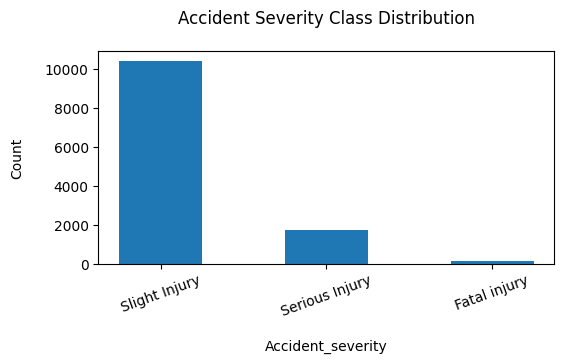

,count
Accident_severity,
Slight Injury,10415
Serious Injury,1743
Fatal injury,158


In [18]:
# Plot 1: Class imbalance
severity_counts = df[target_col].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(severity_counts.index.astype(str), severity_counts.values, width=0.5)
plt.title("Accident Severity Class Distribution", pad=20)
plt.xlabel("Accident_severity", labelpad=15)
plt.ylabel("Count", labelpad=15)
plt.xticks(rotation=20)
plt.tight_layout(pad=2.0)
plt.show()



severity_counts

**Interpretation:**  
The dataset is highly imbalanced (Slight Injury dominates).  
This is why **macro-F1** is used later (it treats minority classes more fairly than accuracy).

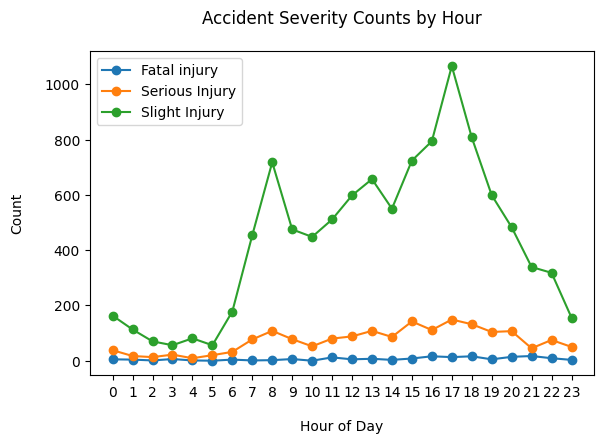

In [19]:
# Plot 2: Accident severity counts by hour (line plot)
if "Hour" in df.columns:
    hour_df = df.dropna(subset=["Hour"]).copy()
    hour_df["Hour"] = hour_df["Hour"].astype(int)

    hours = sorted(hour_df["Hour"].unique())
    classes = list(hour_df[target_col].unique())

    plt.figure()
    for cls in sorted(classes):
        counts = []
        for h in hours:
            count_h = ((hour_df["Hour"] == h) & (hour_df[target_col] == cls)).sum()
            counts.append(count_h)
        plt.plot(hours, counts, marker="o", label=str(cls))

    plt.title("Accident Severity Counts by Hour", pad=20)
    plt.xlabel("Hour of Day", labelpad=15)
    plt.ylabel("Count", labelpad=15)
    plt.legend()
    plt.xticks(hours)
    plt.tight_layout(pad=2.0)
    plt.show()


**Interpretation:**  
There is a clear hourly pattern (peaks around typical commuting times).  
This justifies keeping `Hour` (and also grouping time into `TimeOfDay`).

In [37]:
# Helper: stacked proportion bar chart for top categories
def plot_severity_proportions(df_in, feature_name, top_n=8):
    # Keep only top categories for readability
    top_categories = df_in[feature_name].value_counts().head(top_n).index
    plot_df = df_in[df_in[feature_name].isin(top_categories)].copy()

    # Crosstab and convert to row proportions
    ct = pd.crosstab(plot_df[feature_name], plot_df[target_col])
    ct_prop = ct.div(ct.sum(axis=1), axis=0)

    plt.figure()
    bottom = np.zeros(len(ct_prop))
    for cls in ct_prop.columns:
        plt.bar(ct_prop.index.astype(str), ct_prop[cls].values, bottom=bottom, label=str(cls))
        bottom = bottom + ct_prop[cls].values

    plt.title(f"Accident Severity Distribution by {feature_name} (Top {top_n})",pad=20)
    plt.xlabel(feature_name,labelpad=15)
    plt.ylabel("Proportion",labelpad=15)
    plt.xticks(rotation=35, ha="right")
    plt.legend()
    plt.show()

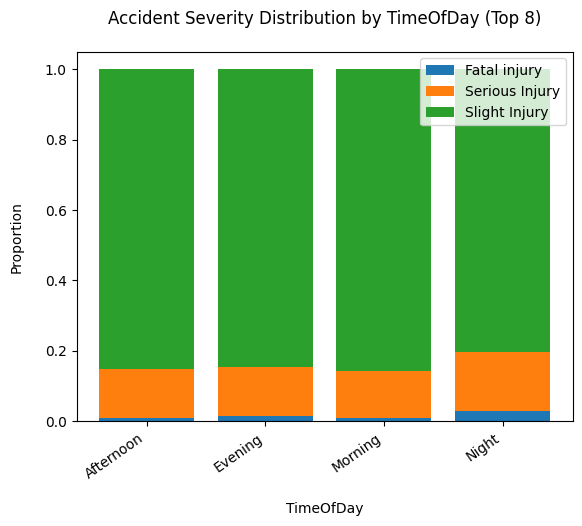

In [38]:
# Plot 3: TimeOfDay distribution
if "TimeOfDay" in df.columns:
    plot_severity_proportions(df, "TimeOfDay", top_n=8)

**Interpretation:**  
Night/Evening categories show relatively higher proportions of serious/fatal outcomes compared to daytime.  
This supports the idea that visibility and risk conditions affect severity.

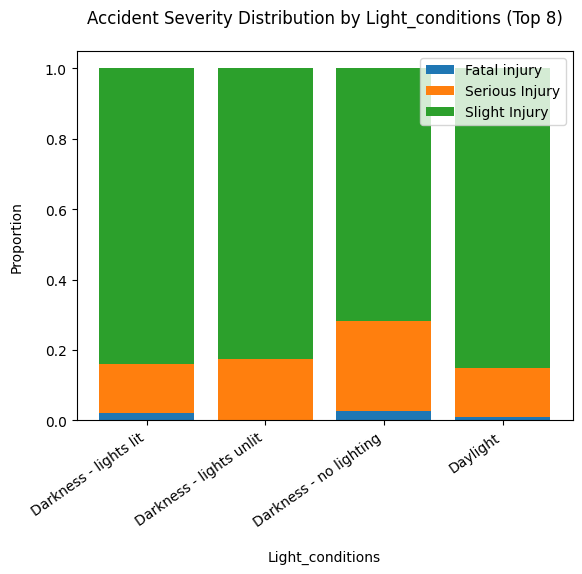

In [39]:
# Plot 4: Light_conditions (top categories)
if "Light_conditions" in df.columns:
    plot_severity_proportions(df, "Light_conditions", top_n=8)

**Interpretation:**  
Darkness-related categories show higher proportions of severe outcomes.  
This matches real-world intuition and supports keeping `Light_conditions`.

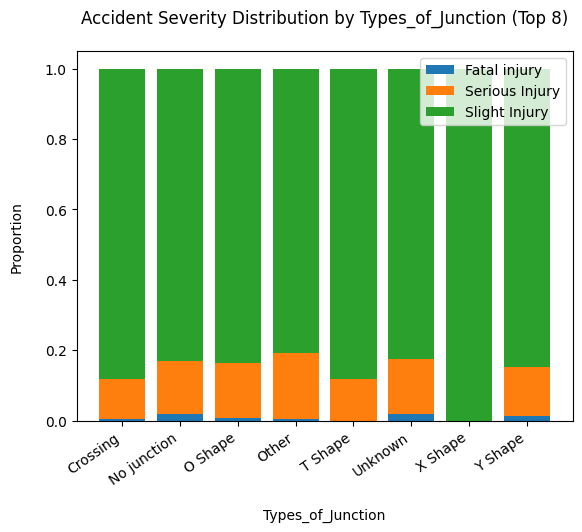

In [40]:
# Plot 5: Types_of_Junction (top categories)
if "Types_of_Junction" in df.columns:
    plot_severity_proportions(df, "Types_of_Junction", top_n=8)

**Interpretation:**  
Different junction types show different severity proportions.  
This suggests road layout (junction type) influences accident outcomes.

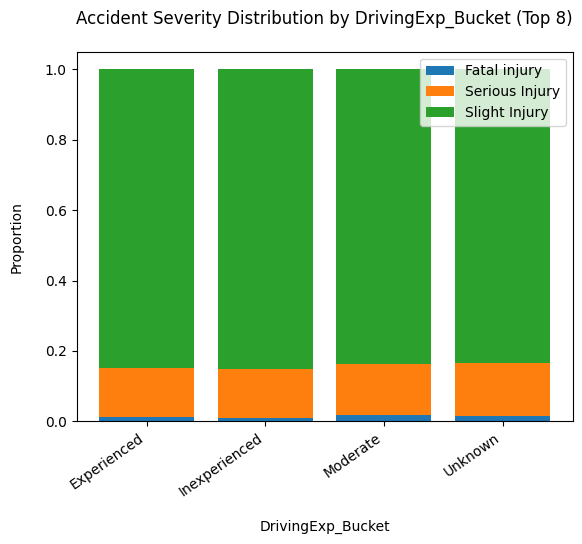

In [41]:
# Plot 6: Driving experience bucket (cleaner than raw categories)
if "DrivingExp_Bucket" in df.columns:
    plot_severity_proportions(df, "DrivingExp_Bucket", top_n=8)

**Interpretation:**  
The bucketed driving experience is easier to interpret than the raw many-category field.  
It helps show whether less experience is associated with higher severity proportions.

## 5. Train/Test Split (Stratified 80/20)

I use a **stratified split** so that each severity class is represented in both train and test sets in similar proportions.


In [20]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col].astype(str)

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train size: (9852, 22) Test size: (2464, 22)
Train class distribution:
Accident_severity
Slight Injury     0.845615
Serious Injury    0.141494
Fatal injury      0.012891
Name: proportion, dtype: float64

Test class distribution:
Accident_severity
Slight Injury     0.845779
Serious Injury    0.141640
Fatal injury      0.012581
Name: proportion, dtype: float64


## 6. Preprocessing Pipeline for Modelling

- Numerical columns: passed through (no scaling needed for tree model; LR will still work on these small counts)
- Categorical columns: OneHotEncode (`handle_unknown='ignore'`)


In [21]:
# Identify columns again based on training data
numeric_features = []
categorical_features = []

for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features (count):", len(categorical_features))

Numeric features: ['Number_of_vehicles_involved', 'Number_of_casualties', 'Hour']
Categorical features (count): 19


In [22]:
# ColumnTransformer for encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

## 7. Model Building (Baseline → Tuned → Neural Network)

**Evaluation focus:** Macro-F1 (important due to imbalance).  
I will store all results in a list so I can show one final comparison table at the end.


In [23]:
results = []  # each entry will be a dictionary for the final comparison table

### 7.1 Model 1 — Logistic Regression (Primary)

- Uses **all preprocessed features** (no feature selection in the primary model, as required by the brief)
- Uses `class_weight='balanced'` to reduce bias toward the majority class


In [24]:
# Pipeline: Preprocess -> Chi-square -> Logistic Regression
logreg_primary = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        solver="saga",          # supports L1 and multinomial
        max_iter=5000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# Fit
logreg_primary.fit(X_train, y_train)

# Predict
y_pred = logreg_primary.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("Logistic Regression (Primary) Test Metrics")
print("Accuracy:", round(acc, 4))
print("Macro Precision:", round(prec, 4))
print("Macro Recall:", round(rec, 4))
print("Macro F1:", round(f1, 4))

results.append({
    "Model": "LogReg (Primary)",
    "Features": "All preprocessed",
    "CV Score (F1-macro)": np.nan,
    "Accuracy": acc,
    "Precision (macro)": prec,
    "Recall (macro)": rec,
    "F1-score (macro)": f1
})

Logistic Regression (Primary) Test Metrics
Accuracy: 0.2573
Macro Precision: 0.3527
Macro Recall: 0.4685
Macro F1: 0.2075


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 7.2 Model 2 — Random Forest (Primary)

- Uses **all preprocessed features** (no feature selection in the primary model)
- Random Forest can model non-linear interactions common in categorical-heavy data


In [25]:
rf_primary = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_primary.fit(X_train, y_train)
y_pred = rf_primary.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("Random Forest (Primary) Test Metrics")
print("Accuracy:", round(acc, 4))
print("Macro Precision:", round(prec, 4))
print("Macro Recall:", round(rec, 4))
print("Macro F1:", round(f1, 4))

results.append({
    "Model": "Random Forest (Primary)",
    "Features": "All preprocessed",
    "CV Score (F1-macro)": np.nan,
    "Accuracy": acc,
    "Precision (macro)": prec,
    "Recall (macro)": rec,
    "F1-score (macro)": f1
})

Random Forest (Primary) Test Metrics
Accuracy: 0.847
Macro Precision: 0.6156
Macro Recall: 0.3362
Macro F1: 0.3114


### 7.3 Logistic Regression (Optimized with CV)

To show improvement, I tune:
- `select__k` (how many chi-square features)
- `model__C` (regularization strength)
- `model__penalty` (L1 vs L2)

I use:
- **Stratified CV**
- `scoring='f1_macro'` (tunes for minority-sensitive performance)


In [26]:
# We tune Logistic Regression on the TRAINING set only.
# Important: we tune using macro-F1 because the dataset is imbalanced.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        solver="saga",
        max_iter=8000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# Key hyperparameters for Logistic Regression:
# - C controls regularization strength (smaller C = stronger regularization)
# - penalty chooses L1 or L2 regularization
param_grid_logreg = {
    "model__C": [0.01, 0.1, 1.0, 3.0],
    "model__penalty": ["l1", "l2"]
}

grid_logreg = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid_logreg.fit(X_train, y_train)

best_logreg_params = grid_logreg.best_params_
best_logreg_cv = grid_logreg.best_score_

print("Best Logistic Regression parameters:", best_logreg_params)
print("Best CV macro-F1:", round(best_logreg_cv, 4))


Best Logistic Regression parameters: {'model__C': 1.0, 'model__penalty': 'l2'}
Best CV macro-F1: 0.309


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 7.4 Random Forest (Optimized with CV)

Random forests can overfit if too deep.  
To go the “extra mile”, I tune key complexity controls:
- `max_depth`
- `min_samples_leaf`
- `min_samples_split`
- `max_features`
- `n_estimators`

I tune using **RandomizedSearchCV** (faster than full grid) and still optimise macro-F1.


In [27]:
# We tune Random Forest on the TRAINING set only.
# Again, we tune using macro-F1 to reward performance on minority classes.

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

# Key hyperparameters for Random Forest:
# - n_estimators: number of trees
# - max_depth: tree depth (controls overfitting)
# - min_samples_split / min_samples_leaf: prevent very tiny leaves
# - max_features: how many features each split considers
param_grid_rf = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [8, 12, 16, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

rand_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_grid_rf,
    n_iter=15,  # keeps runtime reasonable in Colab
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rand_rf.fit(X_train, y_train)

best_rf_params = rand_rf.best_params_
best_rf_cv = rand_rf.best_score_

print("Best Random Forest parameters:", best_rf_params)
print("Best CV macro-F1:", round(best_rf_cv, 4))


Best Random Forest parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 8}
Best CV macro-F1: 0.4768


## 8. Feature Selection (Task 5) + Final Models (Task 6)

Now that we have:
1) **Primary models** (no feature selection)
2) **Optimal hyperparameters** found using cross-validation

…we apply **feature selection** and rebuild the final versions of both models.

**Chosen feature selection method (Filter):** Chi-square (SelectKBest)
- This is a **Week–10 filter method**.
- It ranks features based on their association with the target class.
- We choose *k* using cross-validation on the training set.


In [28]:
# --- 8.1 Choose k (number of selected features) using CV on the TRAIN set ---
# We test a few reasonable k values and pick the one with the best CV macro-F1.

k_candidates = [10, 15, 25, 40]

def pick_best_k(base_pipeline, X_tr, y_tr, k_list, cv_obj):
    best_k = None
    best_score = -1

    for k in k_list:
        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=k)),
            ("model", base_pipeline)
        ])
        scores = cross_val_score(pipe, X_tr, y_tr, cv=cv_obj, scoring="f1_macro", n_jobs=-1)
        mean_score = scores.mean()

        print(f"k = {k} | CV Macro-F1 = {mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    return best_k, best_score


# Base models with best hyperparameters found in Task 4
logreg_best = LogisticRegression(
    solver="saga",
    max_iter=8000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    C=best_logreg_params["model__C"],
    penalty=best_logreg_params["model__penalty"]
)

rf_best = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_jobs=-1,
    n_estimators=best_rf_params["model__n_estimators"],
    max_depth=best_rf_params["model__max_depth"],
    min_samples_split=best_rf_params["model__min_samples_split"],
    min_samples_leaf=best_rf_params["model__min_samples_leaf"],
    max_features=best_rf_params["model__max_features"]
)

print("Selecting k for Logistic Regression:")
best_k_logreg, best_k_logreg_cv = pick_best_k(logreg_best, X_train, y_train, k_candidates, cv)

print("\nSelecting k for Random Forest:")
best_k_rf, best_k_rf_cv = pick_best_k(rf_best, X_train, y_train, k_candidates, cv)

print("\nBest k (LogReg):", best_k_logreg, "| CV Macro-F1:", round(best_k_logreg_cv, 4))
print("Best k (RF):", best_k_rf, "| CV Macro-F1:", round(best_k_rf_cv, 4))


# --- 8.2 Rebuild final models using best hyperparameters + selected features ---
logreg_optimized = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=chi2, k=best_k_logreg)),
    ("model", logreg_best)
])

rf_optimized = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=chi2, k=best_k_rf)),
    ("model", rf_best)
])


def evaluate_and_print(model_name, pipeline, X_tr, y_tr, X_te, y_te):
    # Fit on train
    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_te, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)

    print(f"{model_name} Test Metrics")
    print("Accuracy:", round(acc, 4))
    print("Macro Precision:", round(prec, 4))
    print("Macro Recall:", round(rec, 4))
    print("Macro F1:", round(f1, 4))

    return acc, prec, rec, f1


# Evaluate optimized models on the test set (Task 6 requirement)
logreg_opt_metrics = evaluate_and_print("Logistic Regression (Optimized)", logreg_optimized, X_train, y_train, X_test, y_test)
print()
rf_opt_metrics = evaluate_and_print("Random Forest (Optimized)", rf_optimized, X_train, y_train, X_test, y_test)

# Save results for the final comparison table
results.append({
    "Model": "LogReg (Optimized)",
    "Features": f"Chi-square (k={best_k_logreg})",
    "CV Score (F1-macro)": best_k_logreg_cv,
    "Accuracy": logreg_opt_metrics[0],
    "Precision (macro)": logreg_opt_metrics[1],
    "Recall (macro)": logreg_opt_metrics[2],
    "F1-score (macro)": logreg_opt_metrics[3]
})

results.append({
    "Model": "Random Forest (Optimized)",
    "Features": f"Chi-square (k={best_k_rf})",
    "CV Score (F1-macro)": best_k_rf_cv,
    "Accuracy": rf_opt_metrics[0],
    "Precision (macro)": rf_opt_metrics[1],
    "Recall (macro)": rf_opt_metrics[2],
    "F1-score (macro)": rf_opt_metrics[3]
})


Selecting k for Logistic Regression:
k = 10 | CV Macro-F1 = 0.2551
k = 15 | CV Macro-F1 = 0.2892
k = 25 | CV Macro-F1 = 0.1921
k = 40 | CV Macro-F1 = 0.2270

Selecting k for Random Forest:
k = 10 | CV Macro-F1 = 0.4327
k = 15 | CV Macro-F1 = 0.4431
k = 25 | CV Macro-F1 = 0.4551
k = 40 | CV Macro-F1 = 0.4612

Best k (LogReg): 15 | CV Macro-F1: 0.2892
Best k (RF): 40 | CV Macro-F1: 0.4612


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression (Optimized) Test Metrics
Accuracy: 0.2281
Macro Precision: 0.3475
Macro Recall: 0.4237
Macro F1: 0.1831

Random Forest (Optimized) Test Metrics
Accuracy: 0.7492
Macro Precision: 0.4236
Macro Recall: 0.485
Macro F1: 0.4383


### 7.5 Neural Network (Required) — MLPClassifier (basic build)

The neural network is required by the coursework.  
Here I build a simple MLP (not heavily tuned) to show the model can run and be evaluated fairly.


In [29]:
mlp_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=chi2, k=15)),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=RANDOM_STATE
    ))
])

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("MLP Test Metrics")
print("Accuracy:", round(acc, 4))
print("Macro Precision:", round(prec, 4))
print("Macro Recall:", round(rec, 4))
print("Macro F1:", round(f1, 4))

results.append({
    "Model": "MLP",
    "Features": "Chi-square (k=15)",
    "CV Score (F1-macro)": np.nan,
    "Accuracy": acc,
    "Precision (macro)": prec,
    "Recall (macro)": rec,
    "F1-score (macro)": f1
})

MLP Test Metrics
Accuracy: 0.8523
Macro Precision: 0.7152
Macro Recall: 0.4069
Macro F1: 0.4373


## 8. Final Model Comparison (All 5 Models)

This table summarises the performance of:
- Primary baseline models
- Optimized (CV tuned) versions
- Required neural network

**Key metric:** Macro F1-score (fairer under class imbalance).


In [30]:
results_df = pd.DataFrame(results)

# Keep a clear column order
results_df = results_df[
    ["Model", "Features", "CV Score (F1-macro)", "Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]
]

# Round for readability
results_df_rounded = results_df.copy()
for col in ["CV Score (F1-macro)", "Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"]:
    results_df_rounded[col] = results_df_rounded[col].astype(float).round(4)

results_df_rounded

,Model,Features,CV Score (F1-macro),Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,LogReg (Primary),All preprocessed,NaN,0.2573,0.3527,0.4685,0.2075
1,Random Forest (Primary),All preprocessed,NaN,0.8470,0.6156,0.3362,0.3114
2,LogReg (Optimized),Chi-square (k=15),0.2892,0.2281,0.3475,0.4237,0.1831
3,Random Forest (Optimized),Chi-square (k=40),0.4612,0.7492,0.4236,0.4850,0.4383
4,MLP,Chi-square (k=15),NaN,0.8523,0.7152,0.4069,0.4373
